In [1]:
import os
import json
import numpy as np
import math
import requests
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, hamming_loss, classification_report, multilabel_confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dense, MaxPooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
NUM_CLASSES = 8
NUM_EPOCH = 100
INPUT_SHAPE = (224, 224, 3)
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
LABELS = [
    "shirt, blouse",
    "top, t-shirt, sweatshirt",
    "jacket",
    "pants",
    "skirt",
    "dress",
    "shoe",
    "bag, wallet"
]

In [41]:
# Base Path
DIR_BASE = "/kaggle/input/8-labels-cloth-classification"
OUTPUT_DIR = "/kaggle/working"
cnn_model_path = os.path.join(OUTPUT_DIR, "cnn.h5")
efficient_model_path = os.path.join(OUTPUT_DIR, "efficientB0.h5")

In [4]:
# Dataset paths
img_folder = os.path.join(DIR_BASE, "imgs")
train_annotations = os.path.join(DIR_BASE, "train/data.json")
val_annotations = os.path.join(DIR_BASE, "val/data.json")
test_annotations = os.path.join(DIR_BASE, "test/data.json")

# Function

## Load data

In [5]:
def load_dataset(img_folder, annotation_file, input_size=IMG_SIZE):
    print(annotation_file)
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)

    images = []
    labels = []

    for ann in tqdm(annotations):
        img_path = os.path.join(img_folder, ann["imgPath"])
        label = np.array(ann["labels"])
        bbox_info = ann.get("bbox", [])

        # Load image
        img = load_img(img_path, target_size=input_size)
        img_array = img_to_array(img) / 255.0

        images.append(img_array)
        labels.append(label)

    return np.array(images), np.array(labels)

In [6]:
class ImageDataGenerator(Sequence):
    def __init__(self, img_folder, annotation_file, batch_size=BATCH_SIZE, input_size=IMG_SIZE, shuffle=True):
        self.img_folder = img_folder
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
            
        # Validate annotations
        if not self.annotations or not isinstance(self.annotations, list):
            raise ValueError("Annotations must be a non-empty list")
            
        self.indexes = np.arange(len(self.annotations))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
        print(f"Total images: {len(self.annotations)}")

    def __len__(self):
        return int(np.ceil(len(self.annotations) / self.batch_size))

    def __getitem__(self, idx):
        # Get indexes for current batch
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.annotations))
        batch_indexes = self.indexes[start_idx:end_idx]
        
        # Initialize batch arrays
        batch_size = len(batch_indexes)
        batch_images = np.zeros((batch_size,) + self.input_size + (3,), dtype=np.float32)
        batch_labels = []
        
        # Load images and labels
        for i, idx in enumerate(batch_indexes):
            ann = self.annotations[idx]
            
            # Load and process image
            img_path = os.path.join(self.img_folder, ann["imgPath"])
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image not found: {img_path}")
                
            img = load_img(img_path, target_size=self.input_size)
            img_array = img_to_array(img) / 255.0
            batch_images[i] = img_array
            
            # Get label
            if "labels" not in ann:
                raise KeyError(f"Labels not found in annotation for image: {ann['imgPath']}")
            batch_labels.append(ann["labels"])
            
        batch_labels = np.array(batch_labels, dtype=np.float32)
        
        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

## Custom metric

In [7]:
def custom_accuracy(y_true, y_pred, threshold=0.5):
    """
    Tính độ chính xác tùy chỉnh (custom accuracy) cho bài toán đa nhãn với ngưỡng có thể điều chỉnh.
    
    Args:
        y_true: Tensor của nhãn thực tế (ground truth labels).
        y_pred: Tensor của dự đoán xác suất từ mô hình.
        threshold: Ngưỡng để chuyển xác suất thành nhãn nhị phân (mặc định: 0.5).
    
    Returns:
        Tensor: Độ chính xác trung bình trên tất cả các nhãn.
    """
    # Chuyển y_true về dạng float để tính toán
    # Áp dụng ngưỡng cho predictions để chuyển thành nhãn nhị phân
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred >= threshold, K.floatx())  
    
    # Tính đúng sai từng nhãn
    correct = K.cast(K.equal(y_true, y_pred), K.floatx())
    
    # Tính trung bình chính xác của từng nhãn và sau đó lấy trung bình trên tất cả các nhãn
    label_accuracies = K.mean(correct, axis=0)  # Chính xác trên từng nhãn
    overall_accuracy = K.mean(label_accuracies)  # Trung bình trên tất cả nhãn
    
    return overall_accuracy


In [8]:
def custom_hamming_loss(y_true, y_pred, threshold=0.5):
    """
    Tính Hamming Loss cho bài toán phân loại đa nhãn.
    Hamming Loss là tỷ lệ nhãn bị dự đoán sai trên tổng số nhãn.
    
    Args:
        y_true: Tensor của nhãn thực tế
        y_pred: Tensor của dự đoán xác suất
        threshold: Ngưỡng để chuyển xác suất thành nhãn
    
    Returns:
        Tensor: Hamming Loss
    """
    y_pred = K.cast(y_pred >= threshold, K.dtype(y_true))
    y_true = K.cast(y_true, K.dtype(y_pred))
    
    return K.mean(K.cast(K.not_equal(y_true, y_pred), K.floatx()))

def custom_exact_match_ratio(y_true, y_pred, threshold=0.5):
    """
    Tính tỷ lệ các mẫu có tất cả các nhãn được dự đoán đúng.
    
    Args:
        y_true: Tensor của nhãn thực tế
        y_pred: Tensor của dự đoán xác suất
        threshold: Ngưỡng để chuyển xác suất thành nhãn
    
    Returns:
        Tensor: Tỷ lệ exact match
    """
    y_pred = K.cast(y_pred >= threshold, K.dtype(y_true))
    y_true = K.cast(y_true, K.dtype(y_pred))
    
    # Kiểm tra xem tất cả các nhãn có đúng không
    all_correct = K.all(K.equal(y_true, y_pred), axis=-1)
    return K.mean(K.cast(all_correct, K.floatx()))

## Evalute

In [9]:
def evaluate_multilabel(loaded_model, X_test, y_test, threshold=0.5):
    # Dự đoán từ mô hình
    y_pred_prob = loaded_model.predict(X_test)
    y_pred = (y_pred_prob >= threshold).astype(int)

    # Accuracy
    accuracy = accuracy_score(y_test.flatten(), y_pred.flatten())

    # Tính Hamming Loss
    hamming = hamming_loss(y_test, y_pred)

    # Tính Subset Accuracy
    subset_acc = accuracy_score(y_test, y_pred)

    # Tính Confusion Matrix cho từng nhãn
    ml_cm = multilabel_confusion_matrix(y_test, y_pred)

    # Hiển thị kết quả
    print(f"\033[1mAccuracy: {accuracy:.4f}\033[0m")
    print(f"\033[1mHamming Loss: {hamming:.4f}\033[0m")
    print(f"\033[1mSubset Accuracy: {subset_acc:.4f}\033[0m")

    # Multi-label confusion matrix
    conf_matrices = multilabel_confusion_matrix(y_test, y_pred)
    # Plot confusion matrix for each label
    # Tạo lưới các subplots
    fig, axes = plt.subplots(int(NUM_CLASSES / 4), 4, figsize=(20, 5 * (NUM_CLASSES / 4)))
    axes = axes.flatten()  # Chuyển trục thành mảng 1D để dễ truy cập
    
    # Vẽ từng confusion matrix
    for i in range(NUM_CLASSES):
        sns.heatmap(conf_matrices[i], annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f"Confusion Matrix for Class {i} \n {LABELS[i]}")
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
    
    # Ẩn các ô subplot dư thừa (nếu có)
    for j in range(NUM_CLASSES, len(axes)):
        fig.delaxes(axes[j])
    
    # Hiển thị lưới
    plt.tight_layout()
    plt.show()

    # Classification report
    report = classification_report(
    y_test, y_pred, target_names=LABELS, zero_division=0)
    print(report)
    
    return accuracy, hamming, subset_acc, ml_cm

In [10]:
def plot_training_history(history):
    """
    Vẽ biểu đồ huấn luyện và kiểm tra (validation) của loss và accuracy từ một đối tượng history trong Keras.

    Tham số:
    history (History): Một đối tượng History được trả về từ hàm model.fit().
    """
    plt.figure(figsize=(12, 4))

    # Vẽ biểu đồ loss (mất mát) của huấn luyện và kiểm tra
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Huấn luyện Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Kiểm tra Loss')
    plt.title('Biểu đồ Loss của Mô hình')
    plt.xlabel('Số Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Vẽ biểu đồ accuracy (độ chính xác) của huấn luyện và kiểm tra
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('accuracy', history.history.get('custom_accuracy', [])), label='Huấn luyện Accuracy')
    if 'val_accuracy' in history.history or 'val_custom_accuracy' in history.history:
        plt.plot(history.history.get('val_accuracy', history.history.get('val_custom_accuracy', [])), label='Kiểm tra Accuracy')
    plt.title('Biểu đồ Accuracy của Mô hình')
    plt.xlabel('Số Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Căn chỉnh và hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

# Prepare Data

In [11]:
# Initialize generators
train_generator = ImageDataGenerator(
    img_folder=img_folder,
    annotation_file=train_annotations,
    batch_size=BATCH_SIZE
)

val_generator = ImageDataGenerator(
    img_folder=img_folder,
    annotation_file=val_annotations,
    batch_size=BATCH_SIZE
)

Total images: 35290
Total images: 4411


In [12]:
X_test, y_test = load_dataset(img_folder, test_annotations)

/kaggle/input/8-labels-cloth-classification/test/data.json


100%|██████████| 4412/4412 [00:21<00:00, 203.21it/s]


# CNN

## Build model

In [13]:
# Tạo mô hình CNN
model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Block 4
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Flatten và Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(NUM_CLASSES, activation='sigmoid')
    ])

# Compile mô hình
model.compile(
    # optimizer='adam',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[custom_accuracy, custom_hamming_loss, custom_exact_match_ratio]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         590,0

 Total params: 27,003,176 (103.01 MB)

 Trainable params: 26,999,720 (103.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

## Training

In [15]:
callbacks = [
    # Early Stopping
    EarlyStopping(
        monitor='val_loss',  # Theo dõi
        patience=5,          # Số epochs chờ đợi khi metric không cải thiện
        mode='min',         # Muốn giá trị monitor giảm
        restore_best_weights=True,  # Khôi phục lại trọng số tốt nhất
        verbose=1
    ),
    
    # Model Checkpoint để lưu model tốt nhất
    ModelCheckpoint(
        f'{OUTPUT_DIR}/best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )
]

In [16]:
# Train the model - đã bỏ workers và use_multiprocessing
history = model.fit(
    train_generator,
    epochs=NUM_EPOCH,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - custom_accuracy: 0.6578 - custom_exact_match_ratio: 0.0833 - custom_hamming_loss: 0.3422 - loss: 0.6634
Epoch 1: val_loss improved from inf to 0.69193, saving model to /kaggle/working/best_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 309s 978ms/step - custom_accuracy: 0.6581 - custom_exact_match_ratio: 0.0835 - custom_hamming_loss: 0.3419 - loss: 0.6629 - val_custom_accuracy: 0.7461 - val_custom_exact_match_ratio: 0.0266 - val_custom_hamming_loss: 0.2539 - val_loss: 0.6919
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - custom_accuracy: 0.8111 - custom_exact_match_ratio: 0.2561 - custom_hamming_loss: 0.1889 - loss: 0.4240
Epoch 2: val_loss improved from 0.69193 to 0.39831, saving model to /kaggle/working/best_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 226s 803ms/step - custom_accuracy: 0.8111 - custom_exact_match_ratio: 0.2561 - custom_hamming_loss: 0.1889 - loss: 0.4240 - val_custom_accuracy: 0.8214 - val_custom_exact_match_ratio: 0.2868

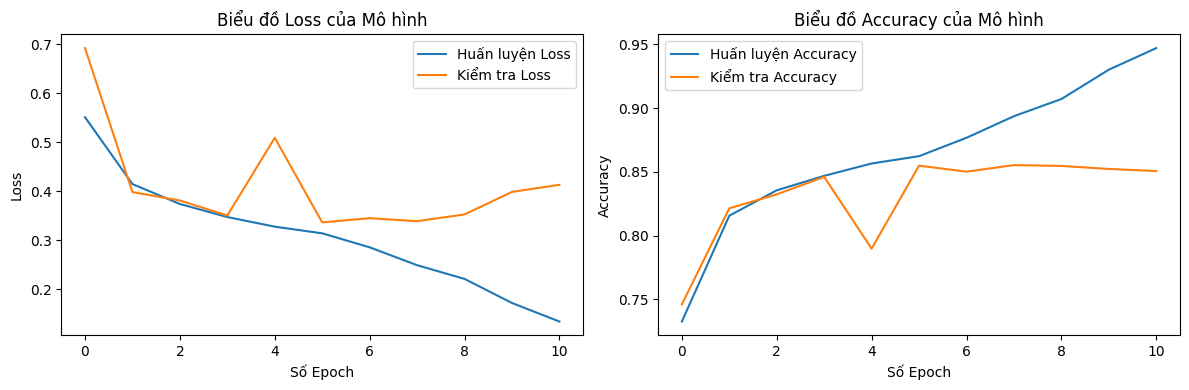

In [17]:
plot_training_history(history)

In [42]:
with open(f"{OUTPUT_DIR}/cnn_history.json", "w") as f:
    json.dump(history.history, f)

# Save the model
model.save(cnn_model_path)

## Evaluate

In [19]:
loaded_model = load_model(cnn_model_path)

138/138 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step
Accuracy: 0.8480
Hamming Loss: 0.1520
Subset Accuracy: 0.3694


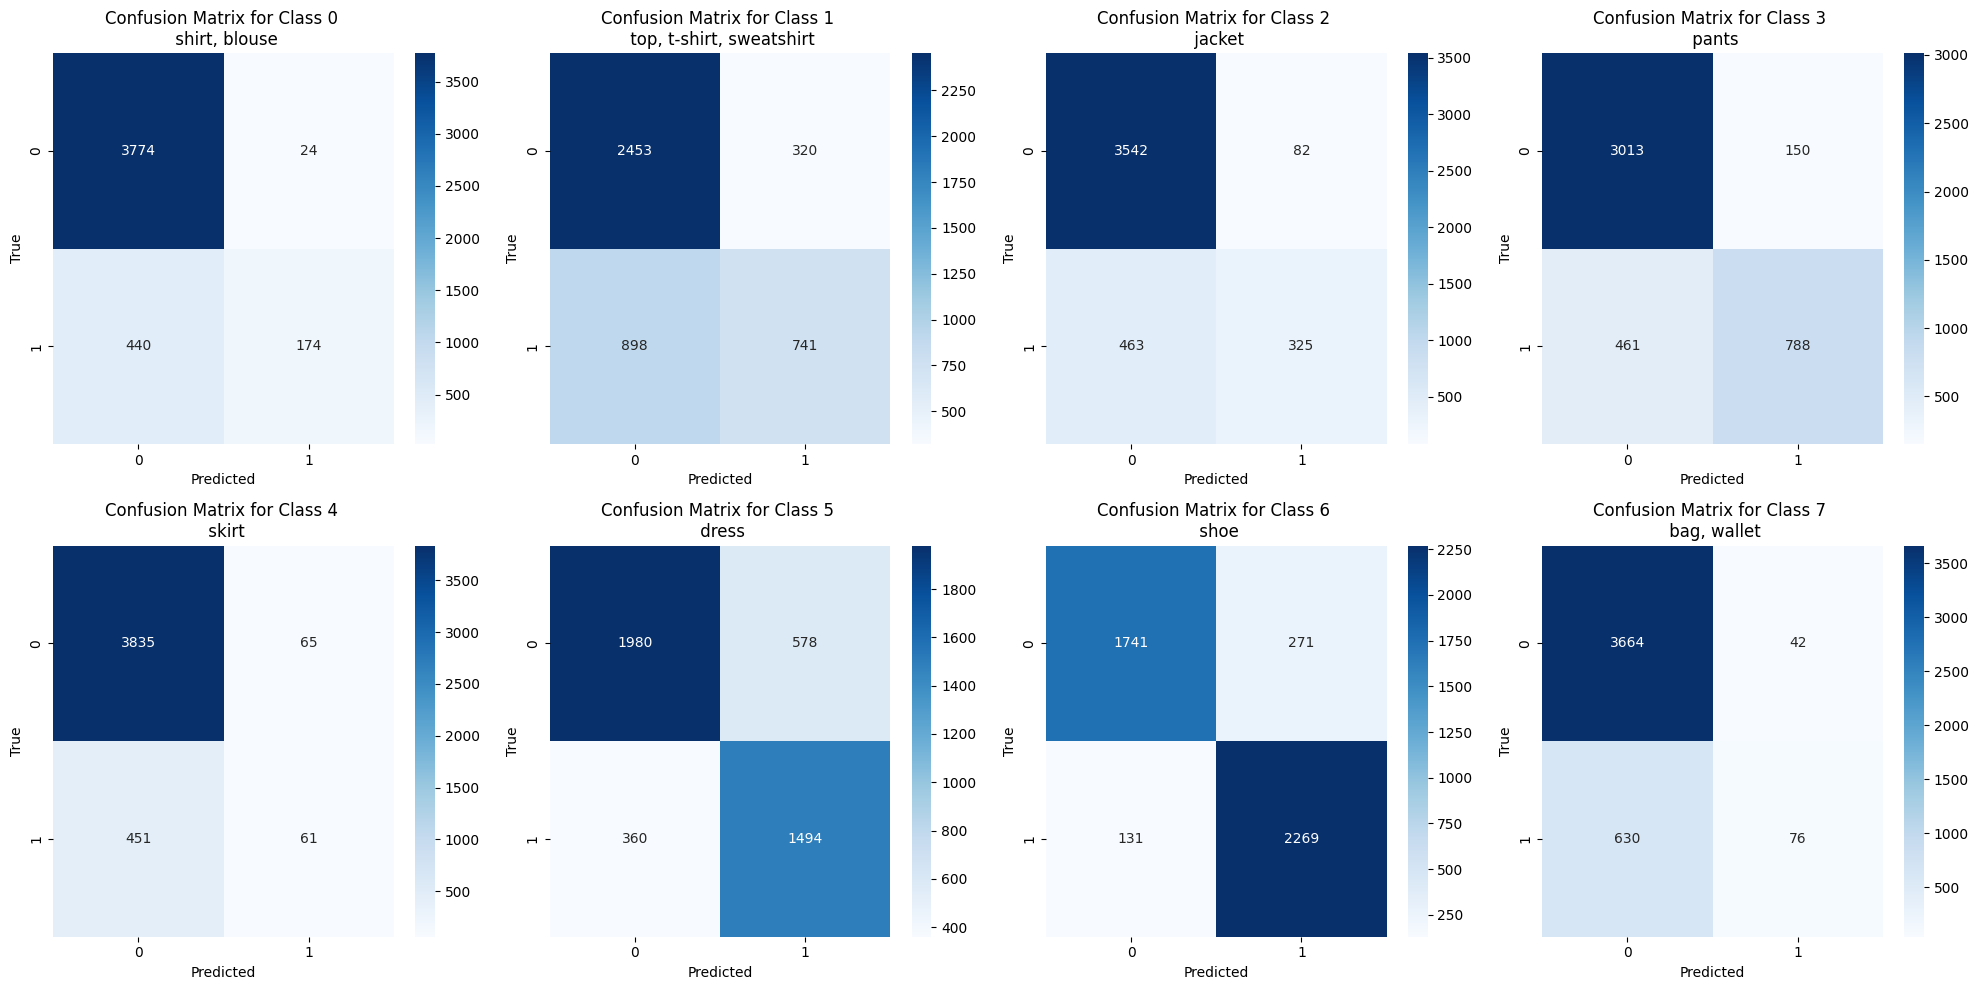

                          precision    recall  f1-score   support

           shirt, blouse       0.88      0.28      0.43       614
top, t-shirt, sweatshirt       0.70      0.45      0.55      1639
                  jacket       0.80      0.41      0.54       788
                   pants       0.84      0.63      0.72      1249
                   skirt       0.48      0.12      0.19       512
                   dress       0.72      0.81      0.76      1854
                    shoe       0.89      0.95      0.92      2400
             bag, wallet       0.64      0.11      0.18       706

               micro avg       0.79      0.61      0.69      9762
               macro avg       0.74      0.47      0.54      9762
            weighted avg       0.77      0.61      0.65      9762
             samples avg       0.73      0.63      0.65      9762



In [20]:
_ = evaluate_multilabel(loaded_model, X_test, y_test, threshold=0.5)

# EfficientNetB0

## Build model

In [21]:
# Build base model
base_model = EfficientNetB0(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')

# Add classification head
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(NUM_CLASSES, activation='sigmoid')(x)

# Create model
efficient_model = Model(inputs=base_model.input, outputs=output)

# Compile model
efficient_model.compile(
    optimizer='adam', 
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  
    metrics=[custom_accuracy, custom_hamming_loss, custom_exact_match_ratio]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Training

In [22]:
# Combine callbacks into a list
callbacks_efficient = [
        EarlyStopping(
        monitor='val_loss',           # Metric to monitor
        patience=5,                   # Number of epochs with no improvement after which training will stop
        mode='min',                   # Training will stop when monitored metric stops decreasing
        restore_best_weights=True,    # Restore model weights from the epoch with the best value of monitored quantity
        verbose=1                     # Print message when early stopping is triggered
    ),
        ModelCheckpoint(
        f'{OUTPUT_DIR}/best_efficient_model.keras',    # Path to save the best model
        monitor='val_loss',           # Metric to monitor 
        save_best_only=True,         # Only save when monitored metric improves
        mode='min',                   # Save when monitored metric is minimized
        verbose=1                     # Print message for each save
    )
]

In [23]:
# Train the model - đã bỏ workers và use_multiprocessing
history_efficient = efficient_model.fit(
    train_generator,
    epochs=NUM_EPOCH,
    validation_data=val_generator,
    callbacks=callbacks_efficient,
    verbose=1
)

Epoch 1/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - custom_accuracy: 0.8517 - custom_exact_match_ratio: 0.3925 - custom_hamming_loss: 0.1483 - loss: 0.3315
Epoch 1: val_loss improved from inf to 0.89822, saving model to /kaggle/working/best_efficient_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - custom_accuracy: 0.8518 - custom_exact_match_ratio: 0.3927 - custom_hamming_loss: 0.1482 - loss: 0.3313 - val_custom_accuracy: 0.6893 - val_custom_exact_match_ratio: 0.0504 - val_custom_hamming_loss: 0.3107 - val_loss: 0.8982
Epoch 2/100
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - custom_accuracy: 0.9158 - custom_exact_match_ratio: 0.5825 - custom_hamming_loss: 0.0842 - loss: 0.2034
Epoch 2: val_loss improved from 0.89822 to 0.48758, saving model to /kaggle/working/best_efficient_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 222s 787ms/step - custom_accuracy: 0.9158 - custom_exact_match_ratio: 0.5825 - custom_hamming_loss: 0.0842 - loss: 0.2034 - val_custom_accuracy: 0.8080 - val_cus

In [46]:
with open(f"{OUTPUT_DIR}/history_efficientB0.json", "w") as f:
    json.dump(history_efficient.history, f)

# Save model ở trạng thái inference
efficient_model.trainable = False

# Compile lại nếu cần
efficient_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Lưu mô hình
efficient_model.save("b0.h5")

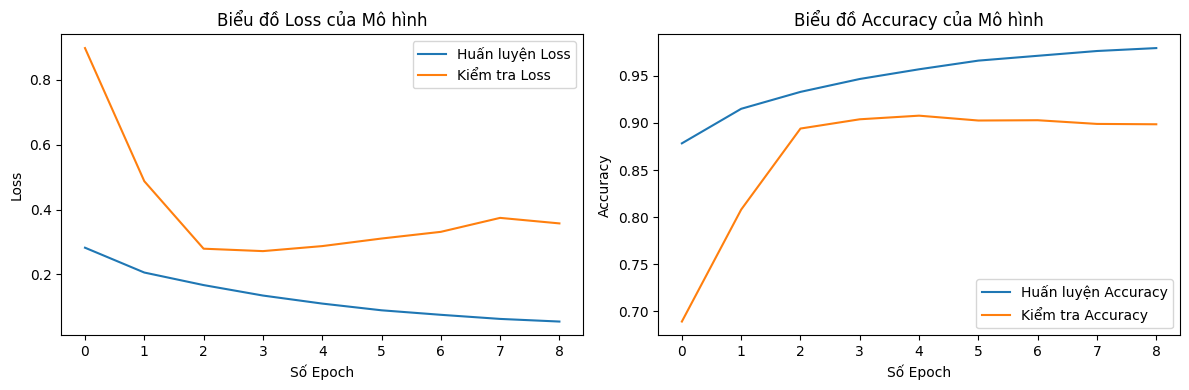

In [25]:
plot_training_history(history_efficient)

## Evalute

In [26]:
loaded_efficient_model = load_model(efficient_model_path)

138/138 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step
Accuracy: 0.8992
Hamming Loss: 0.1008
Subset Accuracy: 0.5474


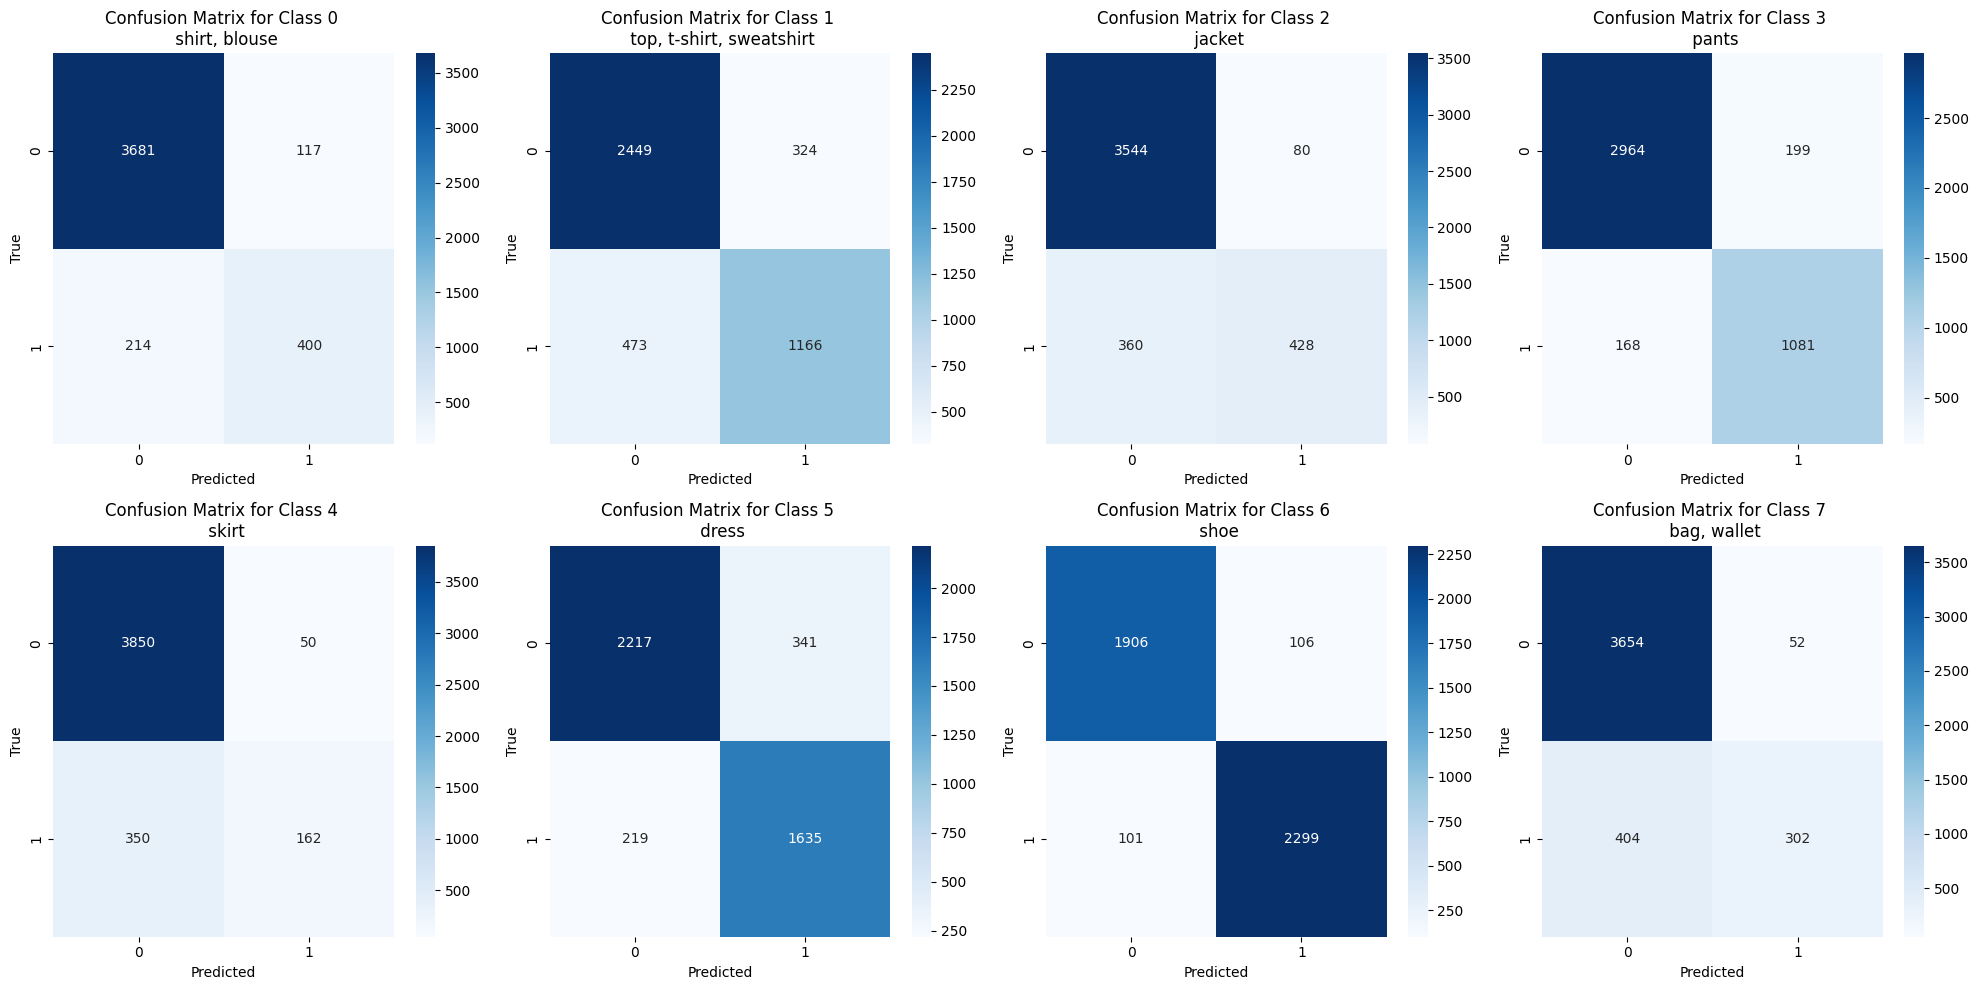

                          precision    recall  f1-score   support

           shirt, blouse       0.77      0.65      0.71       614
top, t-shirt, sweatshirt       0.78      0.71      0.75      1639
                  jacket       0.84      0.54      0.66       788
                   pants       0.84      0.87      0.85      1249
                   skirt       0.76      0.32      0.45       512
                   dress       0.83      0.88      0.85      1854
                    shoe       0.96      0.96      0.96      2400
             bag, wallet       0.85      0.43      0.57       706

               micro avg       0.85      0.77      0.81      9762
               macro avg       0.83      0.67      0.72      9762
            weighted avg       0.85      0.77      0.79      9762
             samples avg       0.84      0.79      0.80      9762



In [27]:
_ = evaluate_multilabel(loaded_efficient_model, X_test, y_test, threshold=0.5)

# Test with new Image

## Func

In [31]:
# Hàm dự đoán
def predict_image(img_array, model):
    img_resized = cv2.resize(img_array, (224, 224))  # Resize để phù hợp với input của model
    img_array = img_resized / 255.0  # Chuẩn hóa giá trị pixel
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)[0]
    predicted_labels = [i for i, prob in enumerate(predictions) if prob > 0.5]
    # print(predictions)

    # Map chỉ số với tên class
    predicted_class_names = [LABELS[i] for i in predicted_labels]

    return predicted_class_names

def load_image_from_url(url):
    """
    Tải ảnh từ URL hoặc từ đường dẫn file local.

    Args:
        url (str): URL hoặc đường dẫn file local của ảnh.

    Returns:
        img (numpy.ndarray): Ảnh được tải dưới dạng mảng numpy.
    """
    if os.path.isfile(url):  # Kiểm tra nếu là đường dẫn file local
        return cv2.imread(url, cv2.IMREAD_COLOR)
    else:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            return cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        else:
            raise ValueError(f"Failed to fetch image from {url}")

def annotate_image_with_labels(img, predicted_class_names):
    """
    Ghi nhãn lên ảnh với nền đen và chữ vàng (font chữ to hơn).

    Args:
        img: Ảnh đầu vào.
        predicted_class_names (list): Danh sách các nhãn được dự đoán.

    Returns:
        img: Ảnh đã được thêm nhãn.
    """
    y_offset = 50  # Vị trí ban đầu của nhãn
    font_scale = 2  # Kích thước font chữ lớn hơn
    thickness = 3  # Độ dày của chữ

    for label in predicted_class_names:
        # Kích thước và tọa độ của nền nhãn
        text_size = cv2.getTextSize(label, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
        text_width, text_height = text_size
        background_start = (10, y_offset - text_height - 10)
        background_end = (10 + text_width + 10, y_offset + 10)
        
        # Vẽ nền màu đen
        cv2.rectangle(img, background_start, background_end, color=(0, 0, 0), thickness=-1)
        
        # Vẽ chữ màu vàng
        cv2.putText(
            img, label, (10, y_offset),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=font_scale,
            color=(0, 255, 255),  # Màu vàng
            thickness=thickness
        )
        y_offset += text_height + 20  # Tăng vị trí cho nhãn tiếp theo
    return img



def process_and_display_images(urls, model, cols=4, figsize=(20, 15)):
    """
    Dự đoán và hiển thị kết quả dựa trên các URL hình ảnh dưới dạng lưới.

    Args:
        urls (list): Danh sách các URL hình ảnh.
        model: Mô hình dùng để dự đoán nhãn hình ảnh.
        cols (int): Số cột trong lưới hiển thị.
        figsize (tuple): Kích thước của hình ảnh hiển thị.
    """
    rows = (len(urls) + cols - 1) // cols  # Tính số hàng cần thiết
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()  # Chuyển mảng axes thành danh sách

    for i, url in enumerate(urls):
        try:
            # Tải ảnh từ URL
            img = load_image_from_url(url)

            # Dự đoán nhãn
            predicted_class_names = predict_image(img, model)

            # Ghi nhãn lên ảnh
            annotated_img = annotate_image_with_labels(img, predicted_class_names)

            # Chuyển đổi màu ảnh từ BGR sang RGB để hiển thị với Matplotlib
            annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

            # Hiển thị ảnh trên lưới
            axes[i].imshow(annotated_img_rgb)
            axes[i].axis('off')
            axes[i].set_title(", ".join(f'"{className}"' for className in predicted_class_names), fontsize=10)

        except Exception as e:
            print(f"Error processing image from URL {url}: {e}")
            axes[i].axis('off')  # Nếu lỗi, để ô trống

    # Ẩn các ô trống nếu số lượng ảnh < hàng x cột
    for j in range(len(urls), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

## Run

In [32]:
# Load CNN models
model = load_model(cnn_model_path)

In [43]:
# Load lại mô hình efficient
loaded_efficient_model = tf.keras.models.load_model(efficient_model_path)

# Đảm bảo inference
loaded_efficient_model.trainable = False
for layer in efficient_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [34]:
# Danh sách URL
urls = [
"/kaggle/input/8-labels-cloth-classification/imgs/0002f5a0ebc162ecfb73e2c91e3b8f62.jpg",
"/kaggle/input/8-labels-cloth-classification/imgs/00d4ade9db192bb8804e44a86b203a5c.jpg",
"/kaggle/input/8-labels-cloth-classification/imgs/01a4d4feb172d8120b753d66d6e5b9e8.jpg",
"/kaggle/input/8-labels-cloth-classification/sample/test1.jpg",
"/kaggle/input/8-labels-cloth-classification/sample/test4.jpg",
"https://i5.walmartimages.com/seo/George-Men-s-Premium-Straight-Fit-Khaki-Pants_f659d317-de24-4b92-bf8d-05e1223a2bf7.c2637e94c3c2c3e9e36485c039e3d0e2.jpeg",
"https://britishretro.co.uk/wp-content/uploads/2023/08/006-red-tartan-50s-full-circle-skirt.jpg",
"https://factorie.com.au/on/demandware.static/-/Sites-catalog-master-factorie/default/dwc47daf5b/5297749/5297749-02-2.jpg",
"https://vulcano.sgp1.digitaloceanspaces.com/media/17830/ao-jacket-3003b-vulcano01.webp",
"https://images.pexels.com/photos/29859973/pexels-photo-29859973/free-photo-of-two-men-shopping-in-urban-mall-setting.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2",
]


## CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


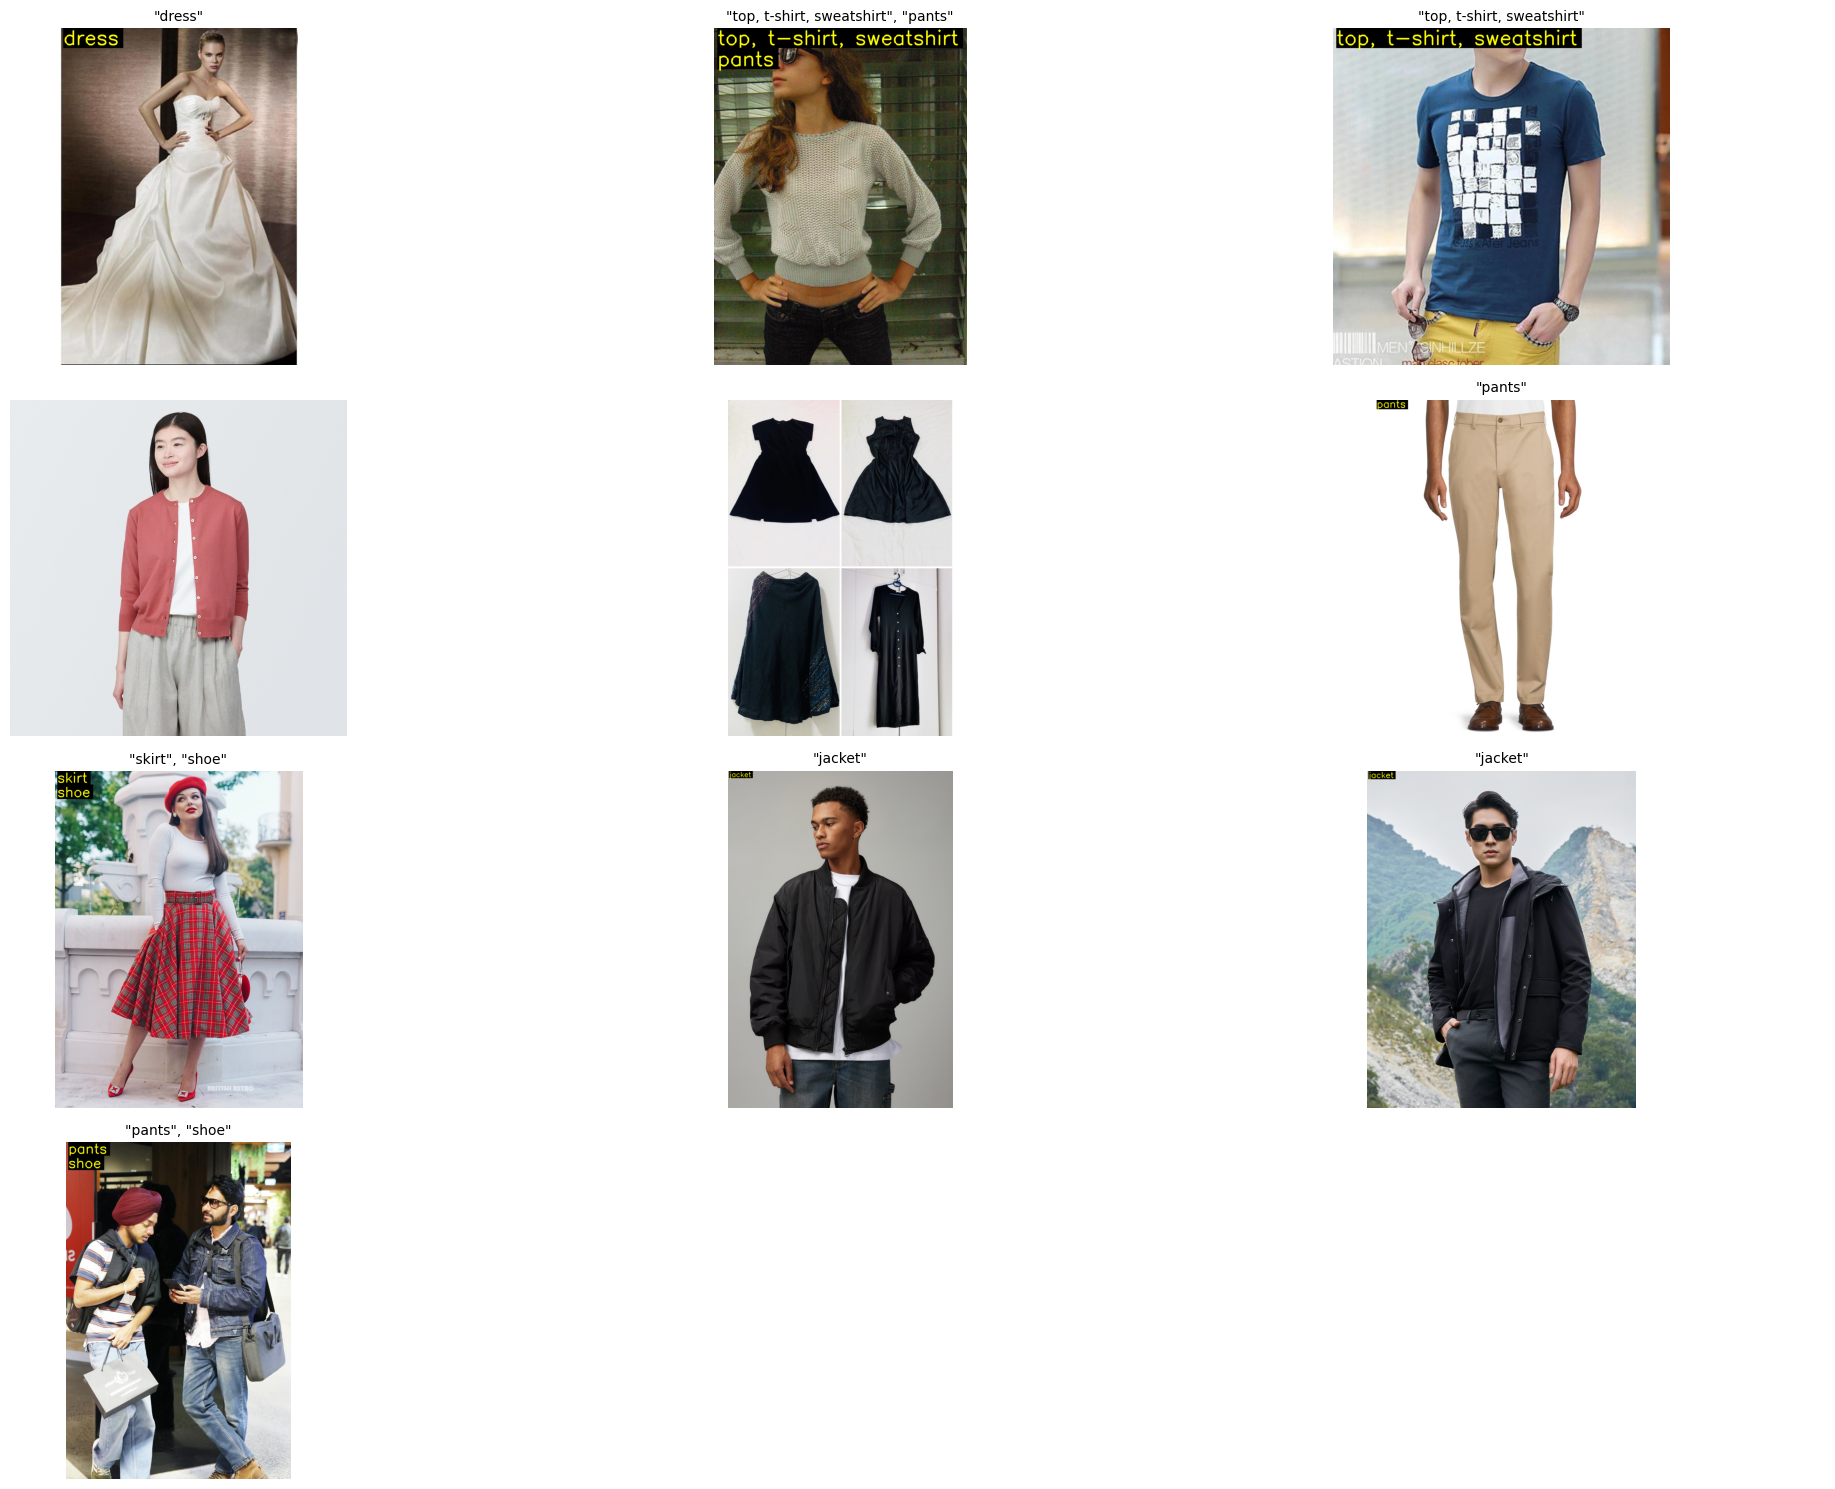

In [38]:
process_and_display_images(urls, model, cols=3)

## efficient

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


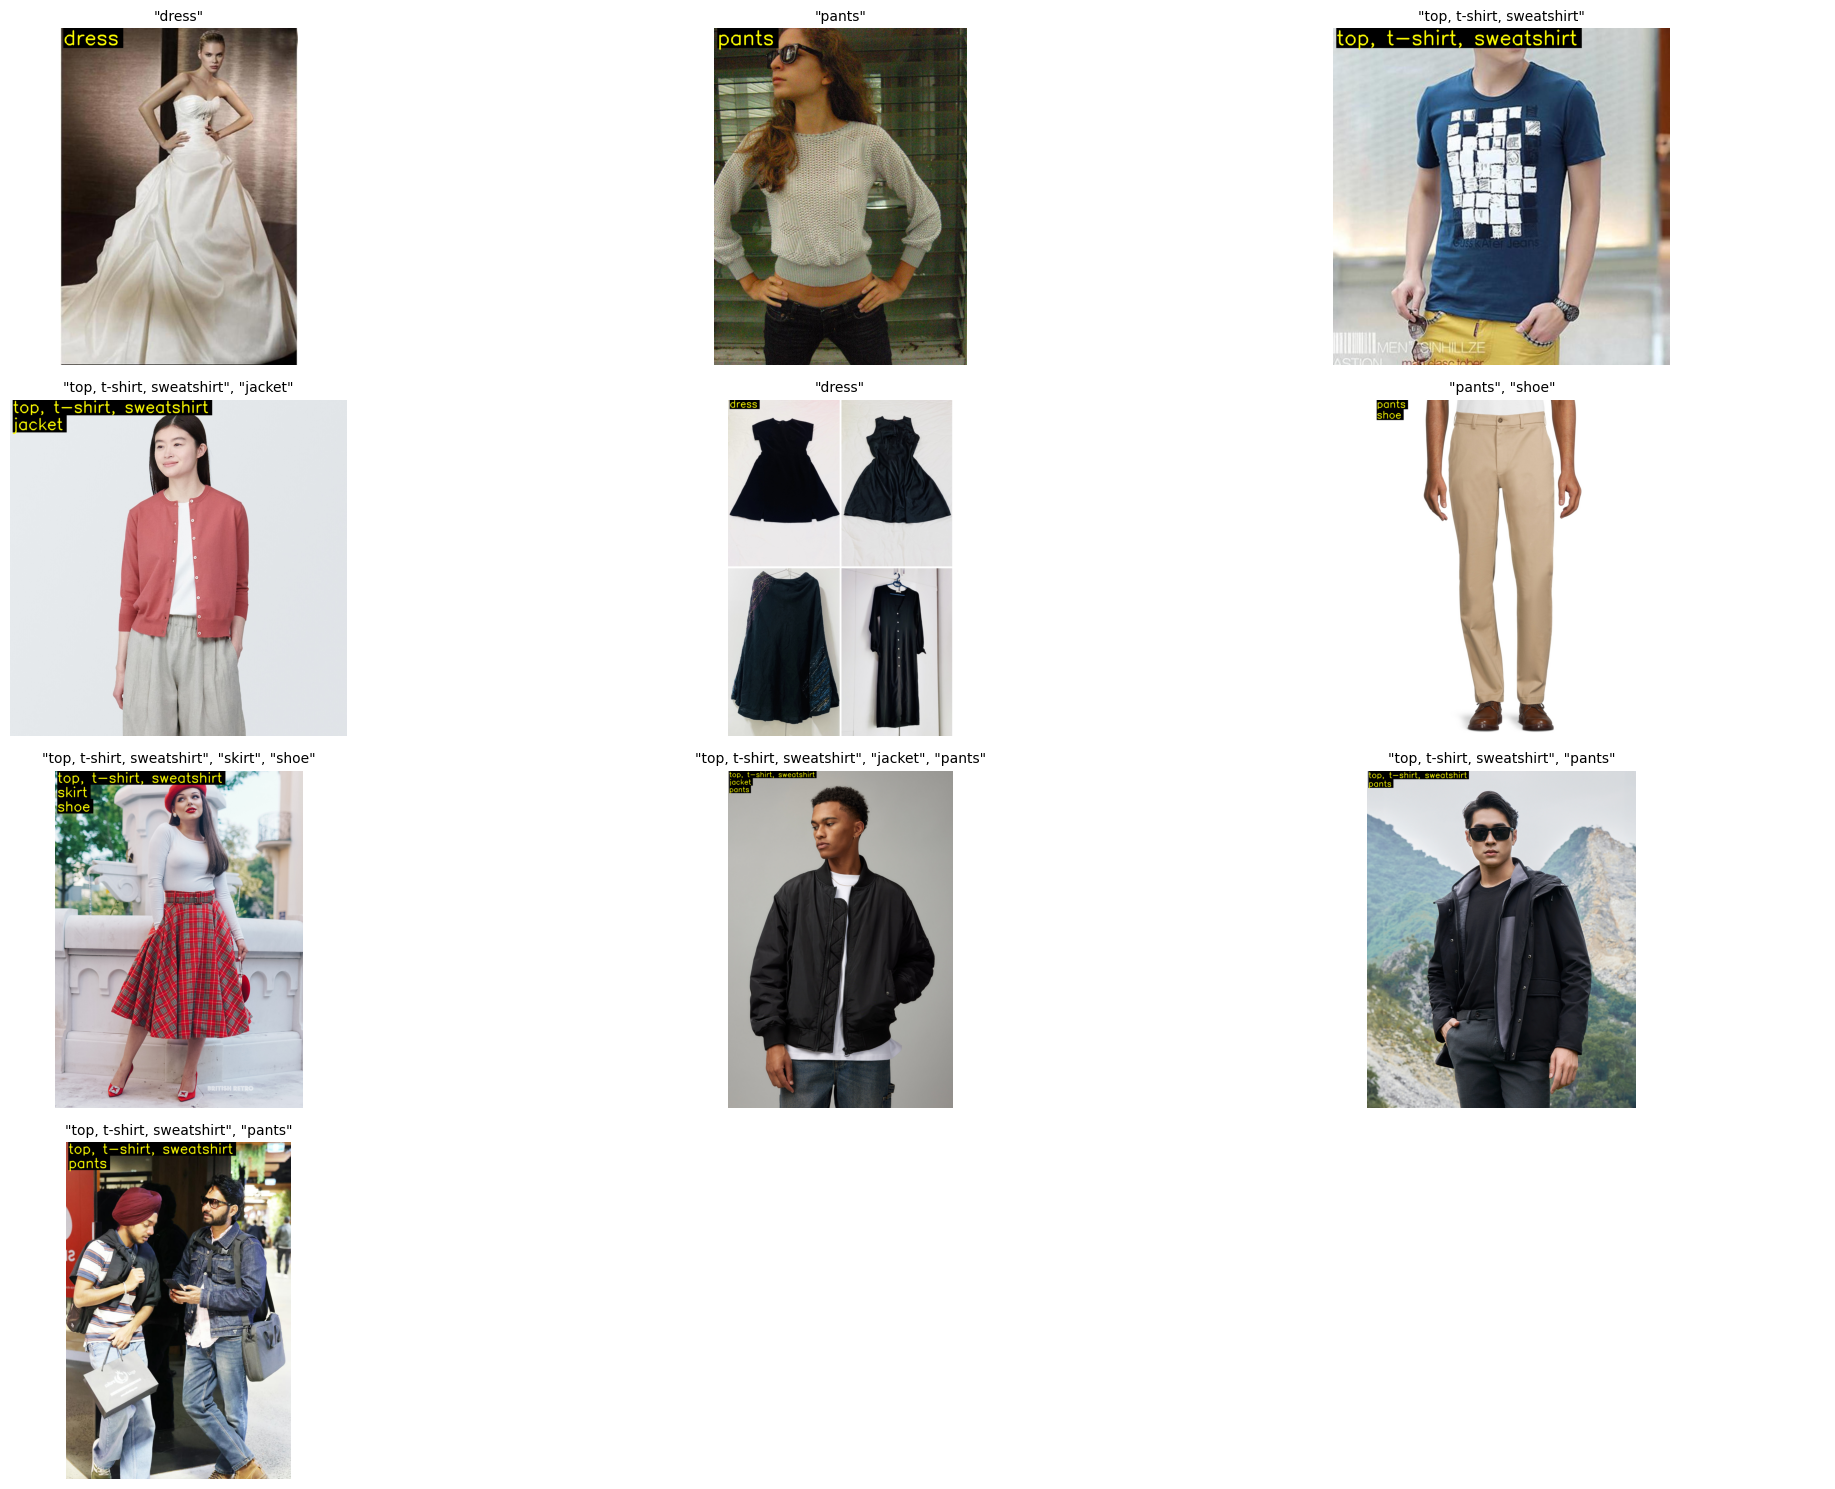

In [45]:
process_and_display_images(urls, loaded_efficient_model, cols=3)